In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jupyter_helpers import *
from helpers import *

In [3]:
best_movies_df.head()

,index,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,MAIN_GENRE,MAIN_PRODUCTION
0,0,David Attenborough: A Life on Our Planet,2020,9.0,31180,83,documentary,GB
1,1,Inception,2010,8.8,2268288,148,scifi,GB
2,2,Forrest Gump,1994,8.8,1994599,142,drama,US
3,3,Anbe Sivam,2003,8.7,20595,160,comedy,IN
4,4,Bo Burnham: Inside,2021,8.7,44074,87,comedy,US


In [44]:
best_movies_df['TITLE'] = best_movies_df['TITLE'].str.lower()
best_movies_df['MAIN_GENRE'] = best_movies_df['MAIN_GENRE'].str.lower()

dls = TextDataLoaders.from_df(
    best_movies_df,
    text_col="TITLE",
    label_col="MAIN_GENRE",
    is_lm=True,
    shuffle=False,
    seq_len=best_movies_df['TITLE'].str.len().max(),
)
dls.show_batch()


,text,text_
0,"xxbos xxunk to xxunk xxbos the xxunk xxbos girl , xxunk xxbos dil xxunk hai xxbos xxunk xxunk xxunk","xxunk to xxunk xxbos the xxunk xxbos girl , xxunk xxbos dil xxunk hai xxbos xxunk xxunk xxunk xxbos"
1,xxbos xxunk xxbos dil xxunk do xxbos xxunk xxunk xxbos xxunk xxunk na xxbos the christmas xxunk xxbos xxunk,xxunk xxbos dil xxunk do xxbos xxunk xxunk xxbos xxunk xxunk na xxbos the christmas xxunk xxbos xxunk xxunk
2,xxunk xxbos xxunk xxunk : xxunk xxunk xxunk xxbos the xxunk xxunk xxbos xxunk xxunk xxbos life in a,xxbos xxunk xxunk : xxunk xxunk xxunk xxbos the xxunk xxunk xxbos xxunk xxunk xxbos life in a xxunk
3,xxunk xxbos xxunk xxbos xxunk xxunk ! xxunk xxunk ! xxbos the xxunk of xxunk xxbos xxunk xxbos xxunk,xxbos xxunk xxbos xxunk xxunk ! xxunk xxunk ! xxbos the xxunk of xxunk xxbos xxunk xxbos xxunk xxunk
4,xxunk xxunk xxbos xxunk xxunk xxbos the xxunk xxunk xxunk xxunk and xxunk xxunk xxbos xxunk xxunk xxbos xxunk,xxunk xxbos xxunk xxunk xxbos the xxunk xxunk xxunk xxunk and xxunk xxunk xxbos xxunk xxunk xxbos xxunk xxbos
5,xxbos kabhi xxunk kabhi xxunk xxbos xxunk xxbos white christmas xxbos the xxunk of xxunk xxbos a xxunk on,kabhi xxunk kabhi xxunk xxbos xxunk xxbos white christmas xxbos the xxunk of xxunk xxbos a xxunk on xxunk
6,xxunk xxunk xxbos xxunk xxbos xxunk xxunk xxunk xxbos the xxunk 's xxunk xxbos the xxunk xxunk xxbos xxunk,xxunk xxbos xxunk xxbos xxunk xxunk xxunk xxbos the xxunk 's xxunk xxbos the xxunk xxunk xxbos xxunk .
7,. xxunk xxbos xxunk dragon xxbos xxunk xxunk : xxunk is xxunk xxbos a xxunk xxunk xxunk xxunk xxbos,xxunk xxbos xxunk dragon xxbos xxunk xxunk : xxunk is xxunk xxbos a xxunk xxunk xxunk xxunk xxbos xxunk
8,xxunk : xxunk xxunk xxunk xxbos xxunk xxunk : a xxunk xxunk movie xxbos once upon a time in,: xxunk xxunk xxunk xxbos xxunk xxunk : a xxunk xxunk movie xxbos once upon a time in xxunk


In [48]:
lm_learn = language_model_learner(dls, AWD_LSTM, metrics=[Perplexity(), accuracy], cbs=[ShowGraphCallback()], drop_mult=0.2)

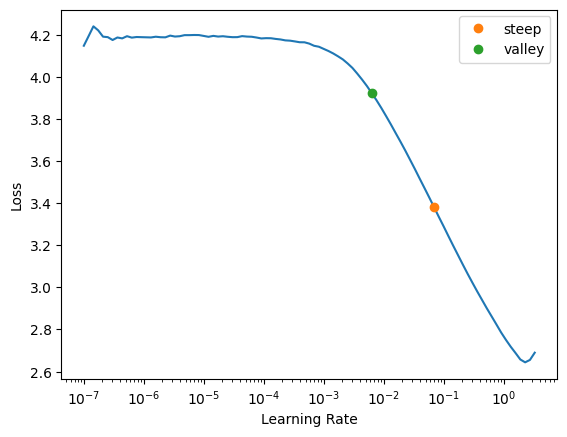

In [46]:
with safely_train_with_gpu():
    lm_learn.lr_find(suggest_funcs=(steep, valley))

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,4.213857,4.732428,113.570930,0.066406,00:00
1,4.111418,3.624003,37.487328,0.332031,00:00
2,3.628345,3.107362,22.361977,0.398438,00:00
3,3.237906,2.821630,16.804224,0.402344,00:00
4,2.951679,2.678307,14.560426,0.394531,00:00
5,2.740737,2.602332,13.495167,0.429688,00:00
6,2.576735,2.580988,13.210179,0.433594,00:00


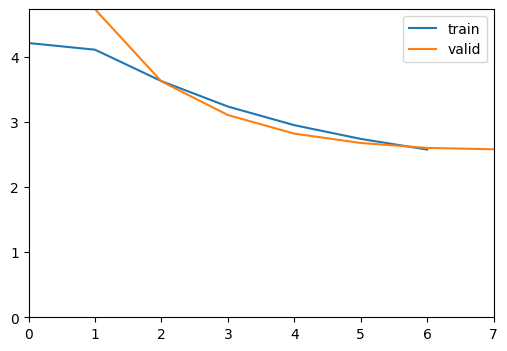

In [47]:
lr = 8e-2

lm_learn.freeze_to(-1)
lm_learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,4.300590,3.579027,35.838650,0.339844,00:00


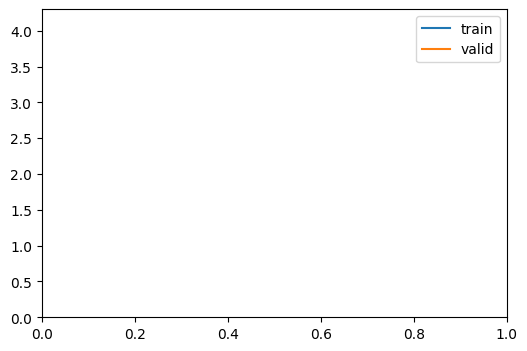

In [49]:
lm_learn.freeze_to(-2)
lm_learn.fit_one_cycle(1, lr/2)

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,2.651334,3.586701,36.114750,0.332031,00:00
1,3.028159,11.693145,119748.000000,0.410156,00:00
2,6.779439,4.194368,66.311798,0.449219,00:00
3,6.020718,3.534191,34.267277,0.449219,00:00
4,5.445498,3.456929,31.719408,0.445312,00:00


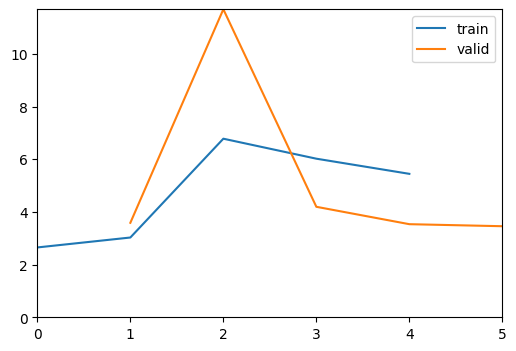

In [50]:

lm_learn.unfreeze()
lm_learn.fit_one_cycle(5, lr/4)

In [51]:
encoder_fn = '2-encoder'
lm_learn.save_encoder(encoder_fn)

In [60]:
(best_movies_df.value_counts('MAIN_GENRE') > 1)

MAIN_GENRE
drama           True
thriller        True
comedy          True
crime           True
romance         True
documentary     True
fantasy         True
horror          True
scifi           True
western         True
action          True
musical         True
animation       True
war             True
sports         False
dtype: bool

In [61]:
text_dls = TextDataLoaders.from_df(
    best_movies_df[~best_movies_df['MAIN_GENRE'].isin((best_movies_df.value_counts('MAIN_GENRE') > 1))],
    text_col="TITLE",
    label_col="MAIN_GENRE",
    is_lm=False,
    shuffle=True,
    seq_len=best_movies_df['TITLE'].str.len().max(),
)
text_dls.show_batch()


text_learn = text_classifier_learner(
    text_dls,
    AWD_LSTM,
    metrics=[accuracy],
    cbs=[ShowGraphCallback()],
    drop_mult=0.5,
    loss_func=CrossEntropyLossFlat(),
)
text_learn.load_encoder(encoder_fn)


,text,category
0,"xxbos xxunk & xxunk : the xxunk xxunk - xxunk a xxunk xxunk , xxunk xxunk xxunk of xxunk xxunk",comedy
1,xxbos xxunk : the xxunk xxunk xxunk i - the xxunk of the king,fantasy
2,xxbos xxunk : the xxunk xxunk xxunk xxunk - the xxunk for xxunk,fantasy
3,xxbos i do xxunk xxunk at xxunk in xxunk xxunk xxunk,drama
4,xxbos xxunk on xxunk : xxunk 's xxunk for xxunk,documentary
5,xxbos legend of the xxunk : the xxunk of xxunk,fantasy
6,xxbos the xxunk xxunk xxunk xxunk and xxunk xxunk,drama
7,xxbos xxunk xxunk xxunk : the xxunk of xxunk,scifi
8,xxbos xxunk : once upon a time in xxunk,drama


SuggestedLRs(steep=0.0691830962896347, valley=0.010964781977236271)

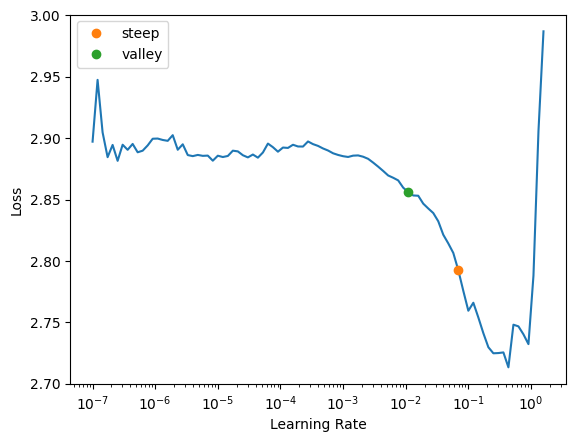

In [62]:
text_learn.lr_find(suggest_funcs=(steep, valley))

epoch,train_loss,valid_loss,accuracy,time
0,2.821089,2.483065,0.467532,00:00
1,2.780953,1.923258,0.467532,00:00
2,2.653517,2.239412,0.467532,00:00
3,2.513241,1.993640,0.467532,00:00
4,2.427501,1.896385,0.467532,00:00


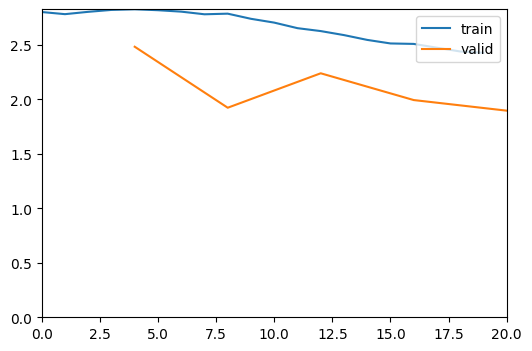

In [ ]:
lr = 5e-2
text_learn.fit_one_cycle(5, lr)